# Spectral Clustering of Countries Economic Development

## Introduction
This notebook aims to investigate if spectral clustering can be applied for the task of grouping the financial growth of 113 countries over the past 58 years. The whole process is documented step by step.

### Imports

In [1]:
import numpy as np
from tslearn.clustering import silhouette_score

from Utils import DataUtils, VisualUtils, TimeSeriesUtils

from Clustering import PreProcessing, SpectralClustering

### Data
For each country, three different time series of data are considered; the annual evolution of its GDP per capita, the annual evolution of its population and the annual evolution of the bilateral exchange rate of its currency against the US Dollar. While there is (partially) available data for the GDP and population evolution all the way from 1900, data about currency exchange rates is only available since 1960. For all three time series, the latest data concerns 2017. In order to stabilize the dataset, all GDP and population data before 1960 is discarded.

Because the GDP time series present very high variance, the logarithm of the series is taken instead to smoothen the results.

The data for each time series is loaded from a `.csv` file to create a $113 \times T$ matrix, where $T$ is the amount of years each time series is available for.

In [2]:
n = 113
T_gdp = 118
T_pop = 118
T_currency = 58
start_year = 1960

names_path = "Data/names.txt"
gdp_path = "Data/yp_raw.csv"
population_path = "Data/pop_raw.csv"
currency_path = "Data/currency.csv"

In [3]:
names, gdp, pop, currency = DataUtils.load_clustering_data(
    names_path, gdp_path, population_path, currency_path, n, T_gdp, T_pop, T_currency
)
gdp_data = np.log(gdp[:, -T_currency:])
pop_data = pop[:, -T_currency:]

## Data Preparation
Before the clustering algorithms are applied, the time series data is concatenated for all countries and then standardized.

One complication that arises for currency exchange rate data when it comes to countries of former Yugoslavia and USSR. For these countries (Serbia, Croatia, Bosnia and Herzegovina and Russia respectively) no data is available until 1990. To tackle this problem, a nearest neighbor imputer is used to fill the empty values.

In [4]:
df, scaled_df = PreProcessing.preprocess(
    names, gdp_data, pop_data, currency, start_year
)

In [5]:
df_gdp, scaled_df_gdp, scaled_data_gdp = PreProcessing.preprocess_onlyGDP(names, gdp_data, start_year, T_currency)

## Spectral Clustering

We examine three different ways of building the similarity graph; a euclidean $k$-nearest neighbor graph, an $\epsilon$-neighborhood graph and a DTW $k$-nearest neighbor graph.

In order to tune the number of clusters for the algorithm, the 'eigenvalue' heuristic is used. Specifically, we examine the magnitude of the eigenvalues of the Laplacian matrix of the graph $L$, and take K clusters such that the smallest eigenvalues $\lambda_1$, ..., $\lambda_K$ are significantly smaller than the rest. Afterwards, we examine the information captured by the corresponding eigenvectors. We reduce the number of clusters by one for each eigenvector that does not capture any significant information.

### $k$-nearest neighbor graph:

We use $k=\lfloor \sqrt{n} \rfloor$ neighbors, where $n$ is the number of countries, i.e. 113. 

In [6]:
W_knn = SpectralClustering.knn_graph(n, scaled_df)

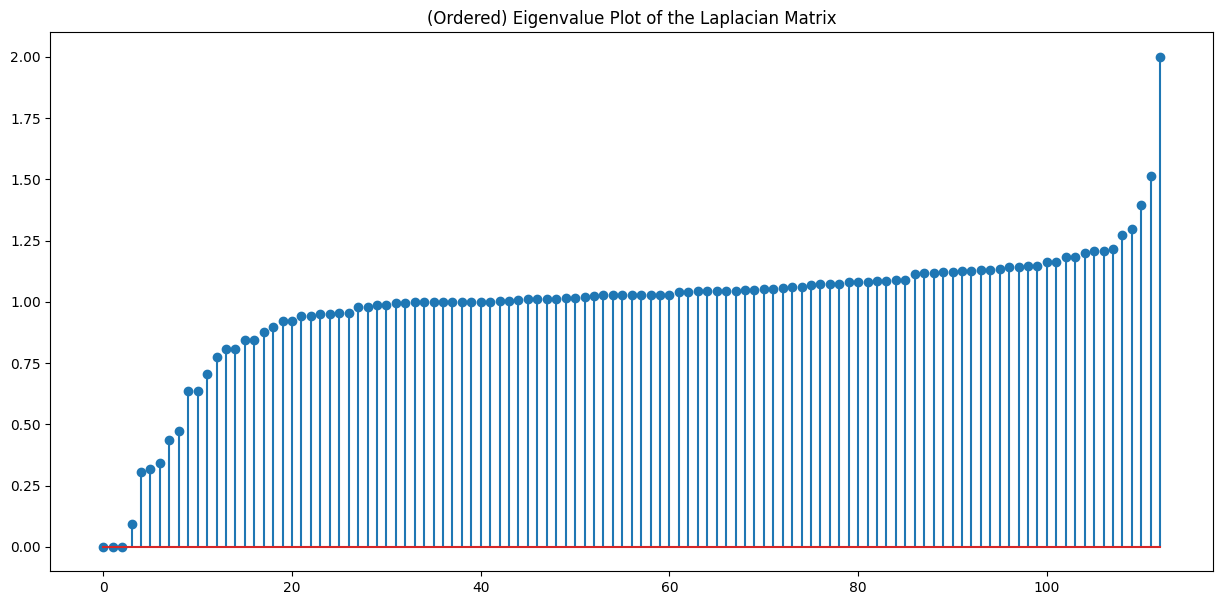

In [7]:
eigvals_knn_norm, eigvecs_knn_norm = SpectralClustering.laplacian_eigen(
    n, W_knn, True, True
)

We conclude 4 clusters are sufficient. We create the H matrix:

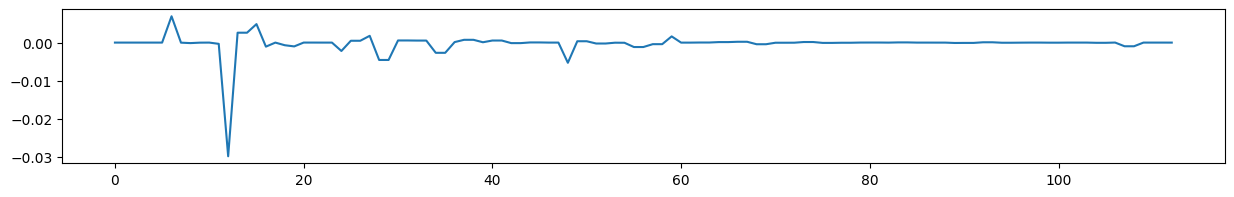

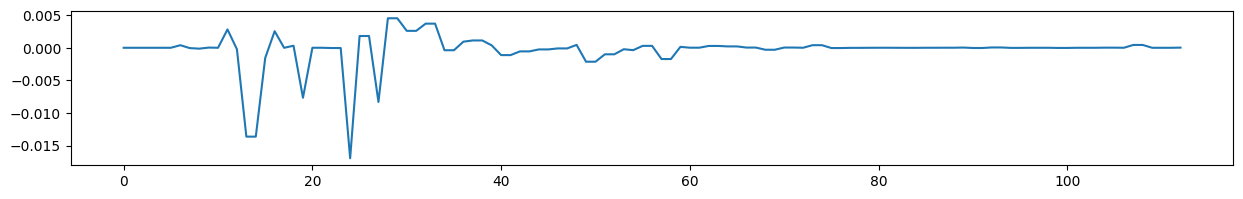

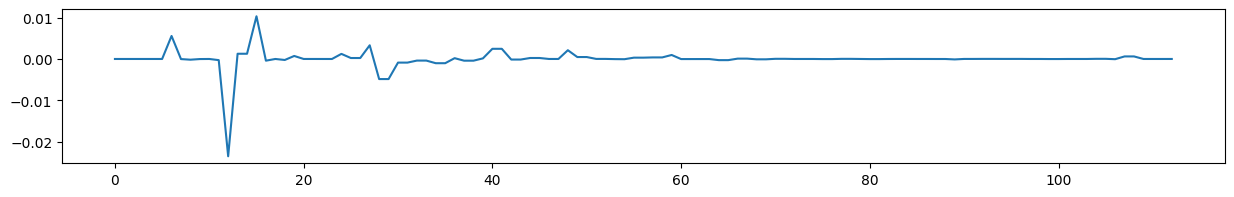

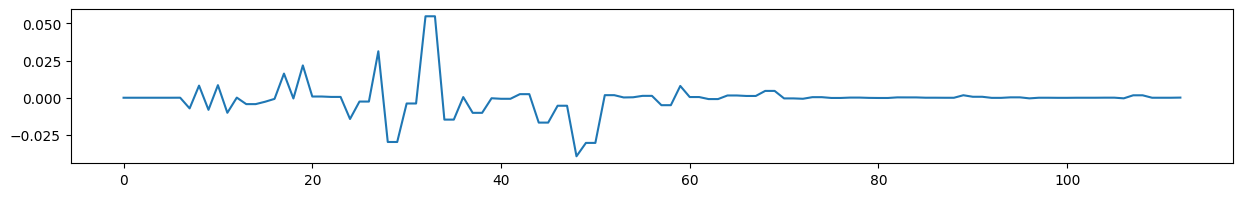

In [8]:
K_knn = 4
H_knn = SpectralClustering.smallest_eigenvecs(
    n, K_knn, eigvals_knn_norm, eigvecs_knn_norm, True
)

All of the eigenvectors are relevant, so now we can perform the clustering with 4 clusters

Silhouette Score: -0.17221412827303034
Cluster #0 size: 98
Cluster #0 members: ARG, AUS, AUT, BDI, BEL, BEN, BFA, BGD, BGR, BIH, BOL, BRA, CAN, CHE, CHL, CHN, CIV, CMR, COG, COL, CRI, DEU, DOM, DZA, ETH, FIN, GRC, GTM, HKG, HND, HRV, HTI, HUN, IDN, IRN, IRQ, JPN, KEN, KHM, KOR, LAO, LBN, LBR, LKA, MAR, MDG, MEX, MLI, MMR, MNG, MOZ, MRT, MWI, MYS, NER, NGA, NIC, NLD, NOR, NPL, NZL, OMN, PAK, PAN, PER, PHL, POL, PRT, PRY, PSE, ROU, RUS, RWA, SAU, SDN, SEN, SGP, SLE, SLV, SRB, SWE, SYR, TCD, TGO, THA, TUN, TUR, TWN, TZA, UGA, URY, USA, VEN, VNM, YEM, ZAF, ZMB, ZWE
Cluster #1 size: 4
Cluster #1 members: COD, ECU, FRA, GBR
Cluster #2 size: 10
Cluster #2 members: DNK, EGY, ESP, GHA, GIN, IND, IRL, ISR, ITA, JOR
Cluster #3 size: 1
Cluster #3 members: CAF


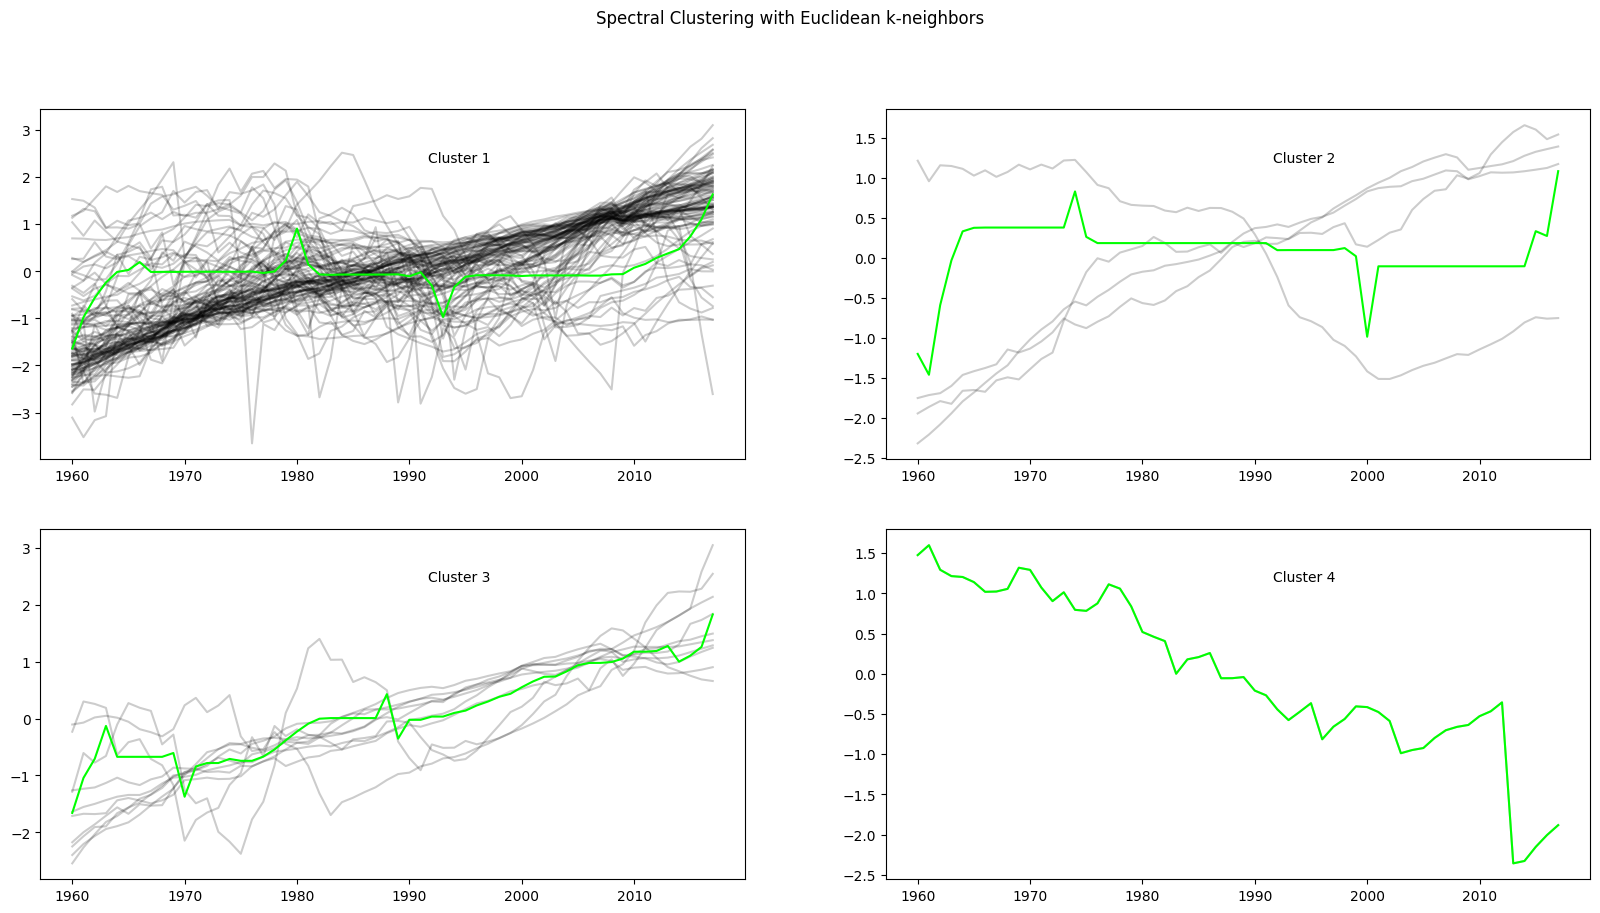

In [9]:
labels_knn = SpectralClustering.kmeans(
    H_knn, K_knn
)

score_knn = silhouette_score(scaled_data_gdp, labels_knn)
cluster_centers_knn = TimeSeriesUtils.cluster_centroids(scaled_data_gdp, K_knn, labels_knn, T_currency)
clusters = VisualUtils.show_clustering(
    names, 
    K_knn, 
    scaled_data_gdp, 
    cluster_centers_knn, 
    labels_knn, 
    score_knn, 
    2, 
    2, 
    start_year, 
    T_currency, 
    "Spectral Clustering with Euclidean k-neighbors"
)

### $\epsilon$-neighborhood graph:

In order for the similarity graph to be sparse, we set $\epsilon$ to the 10th percentile of the distances.

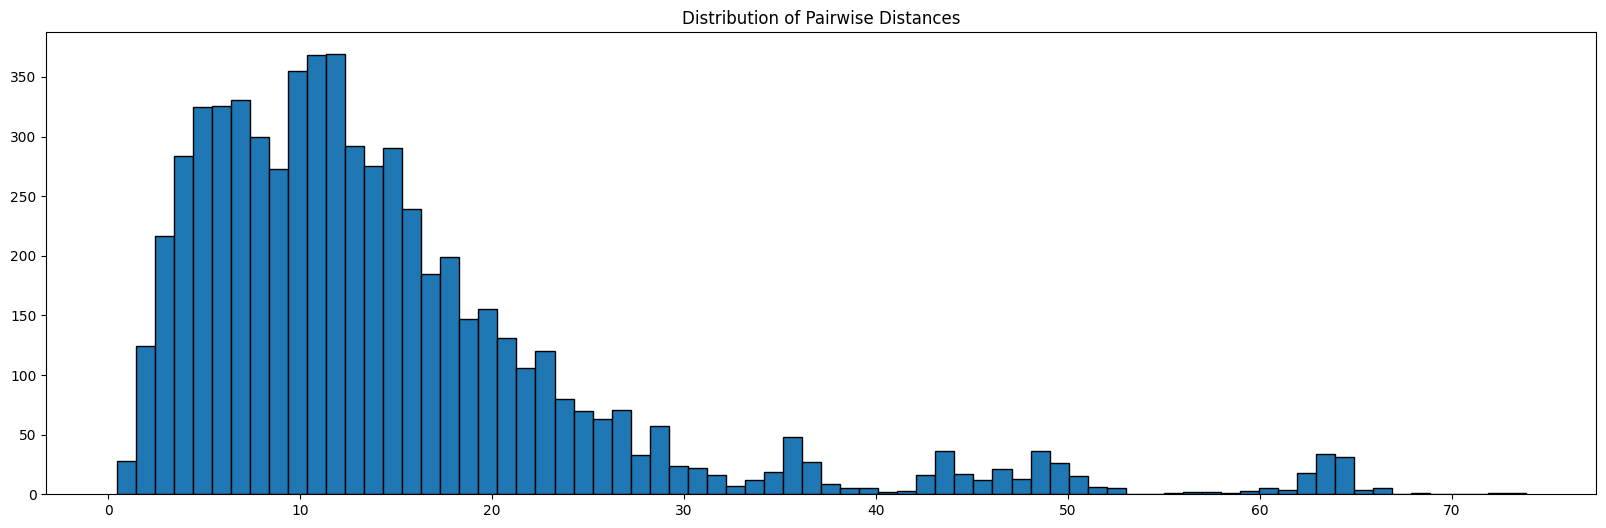

epsilon = 4.337176308344732


In [10]:
W_eps = SpectralClustering.epsilon_graph(
    scaled_df, 10, True
)

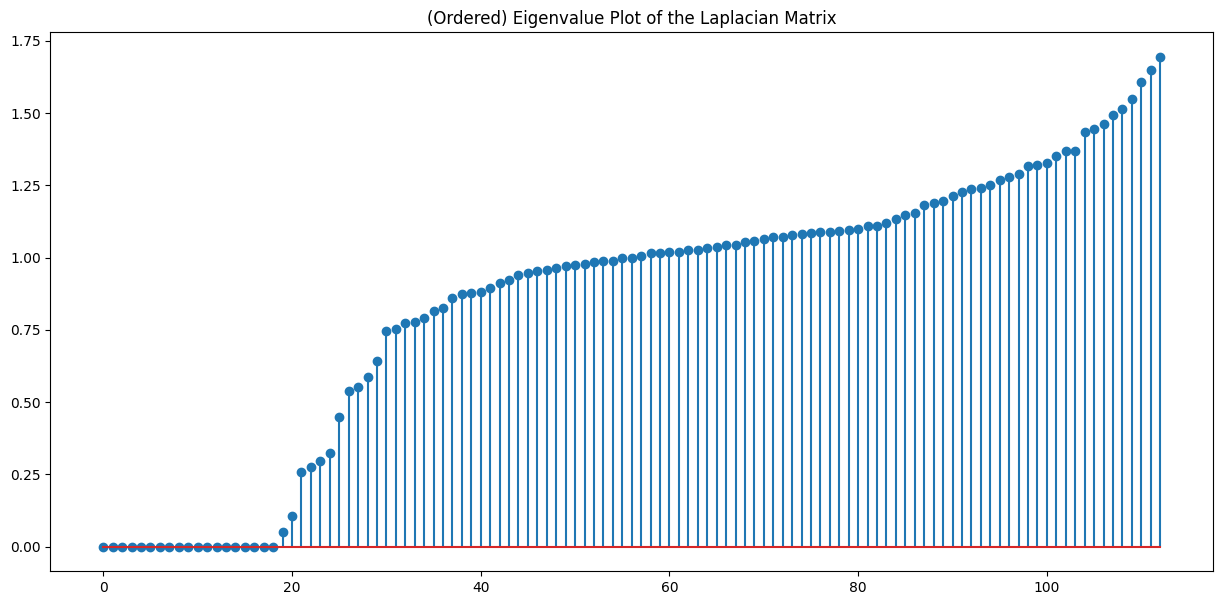

In [11]:
eigvals_eps_norm, eigvecs_eps_norm = SpectralClustering.laplacian_eigen(
    n, W_eps, True, True
)

We conclude 21 clusters are sufficient. We create the H matrix:

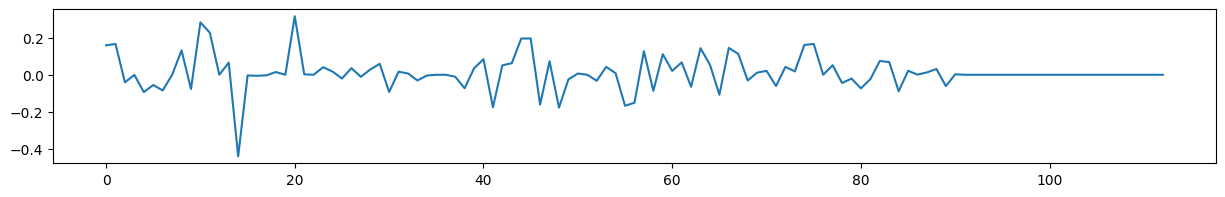

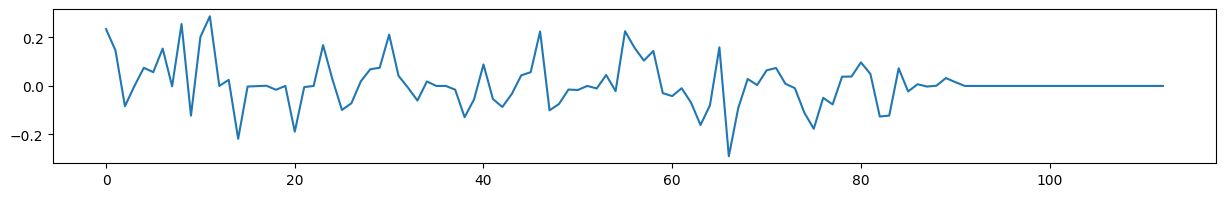

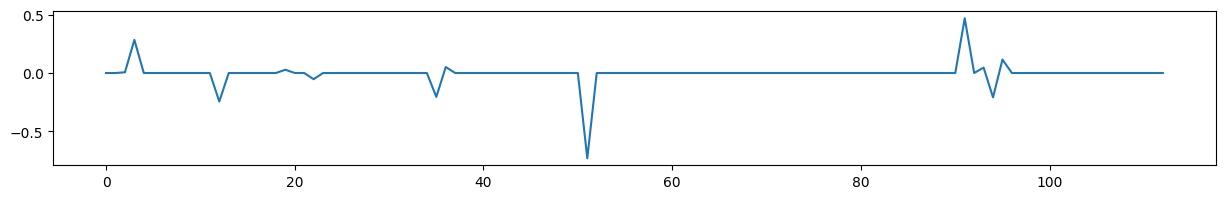

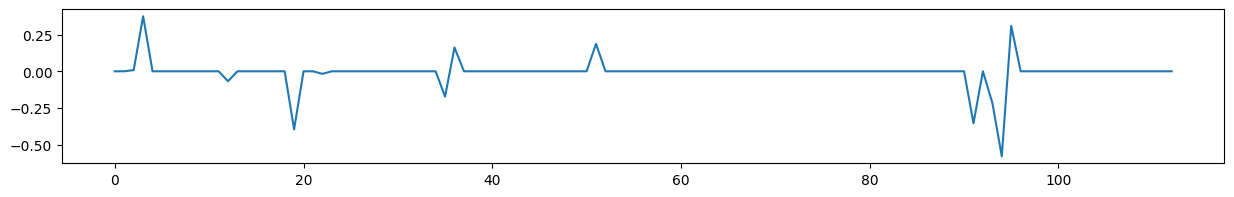

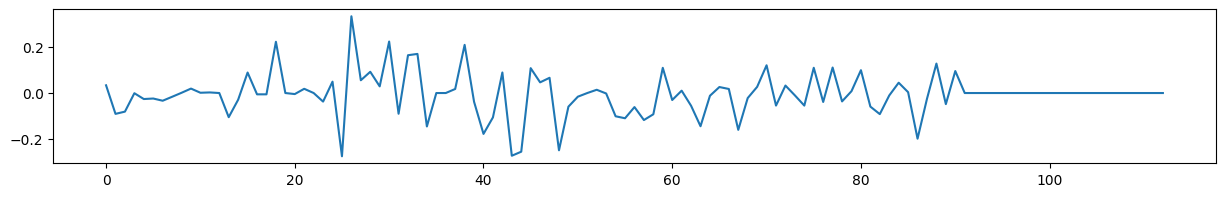

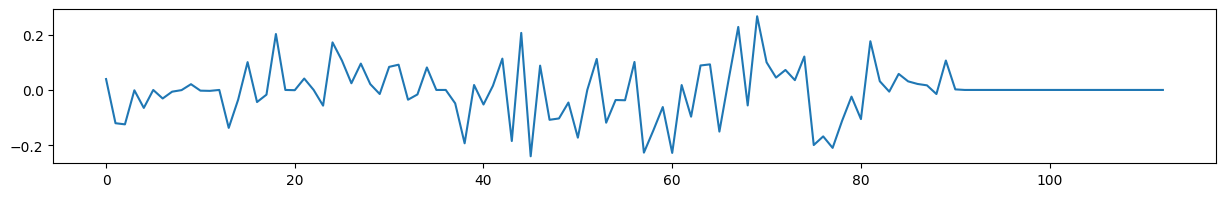

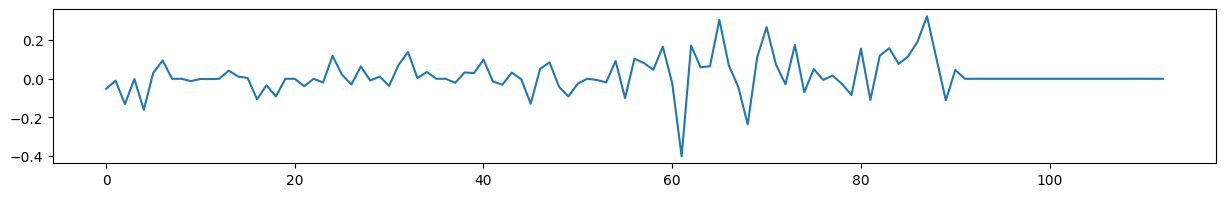

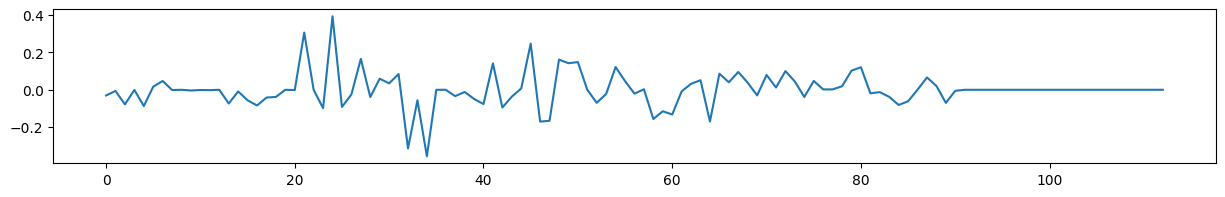

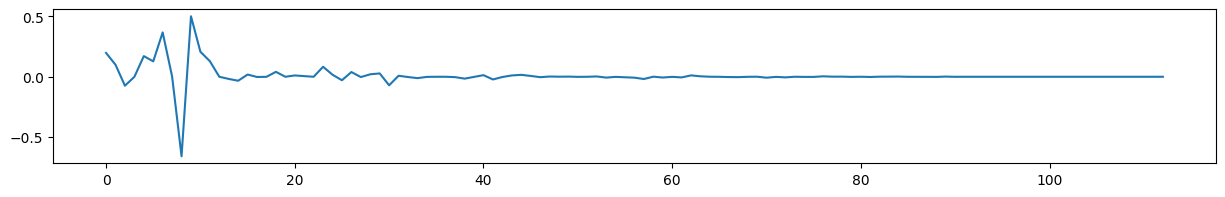

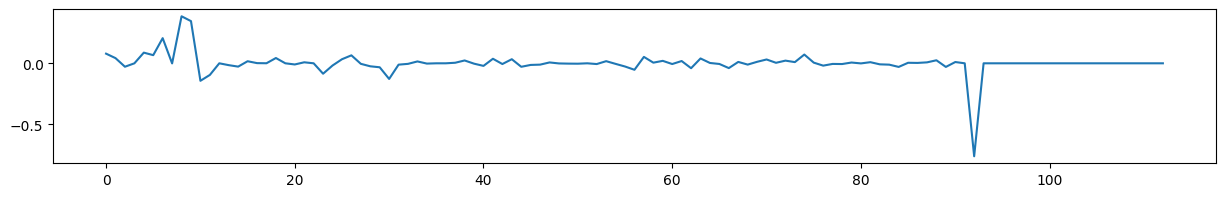

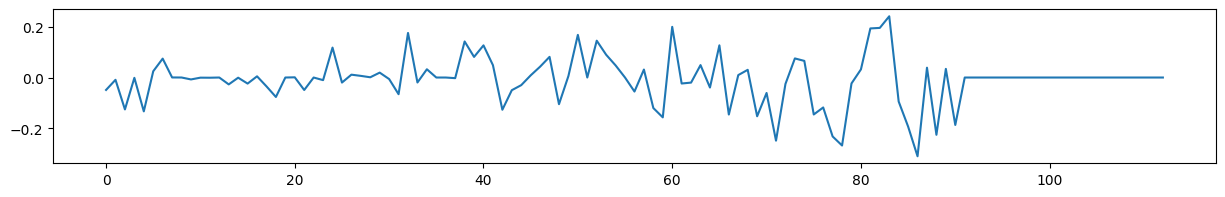

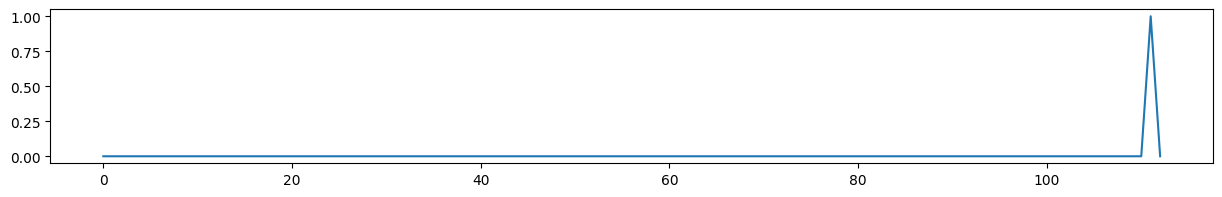

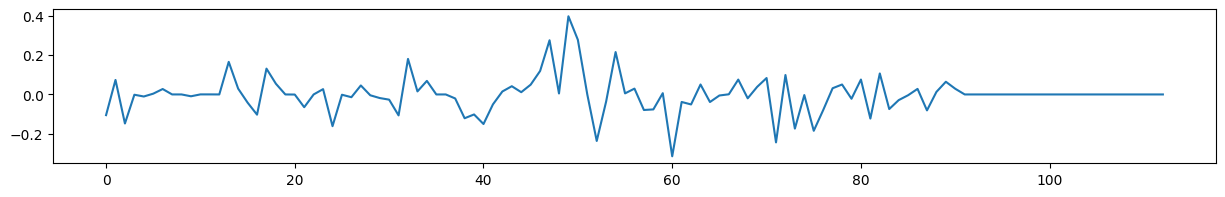

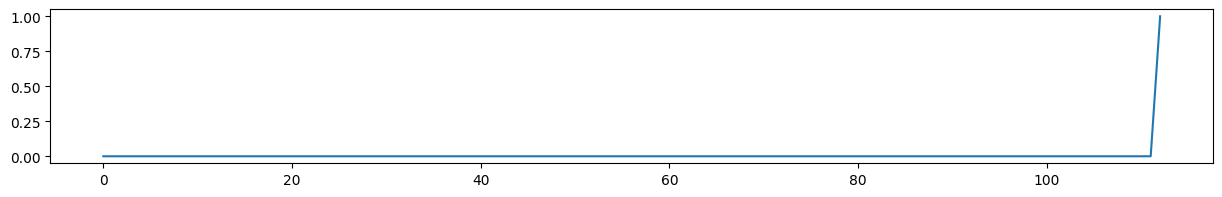

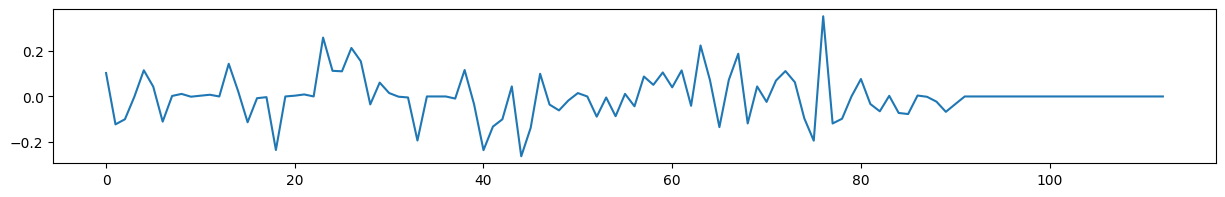

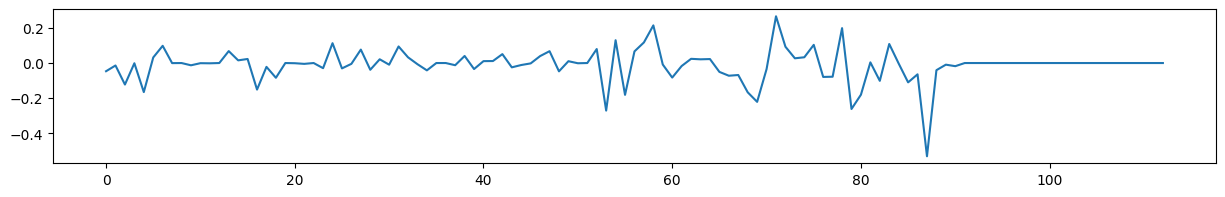

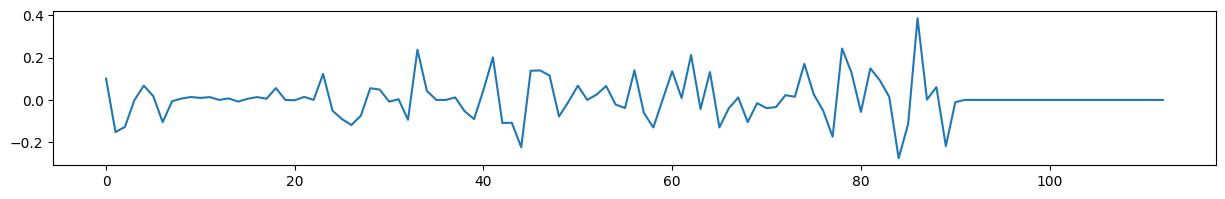

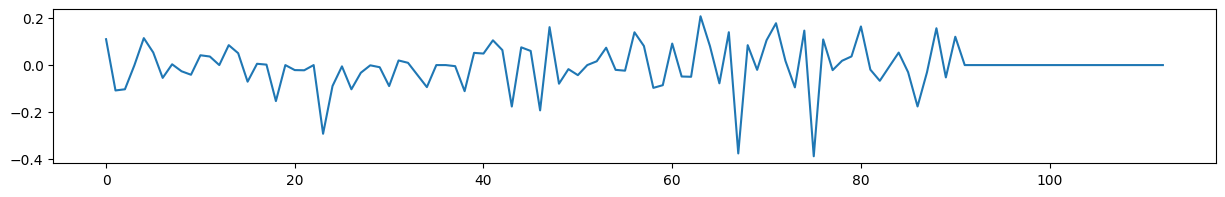

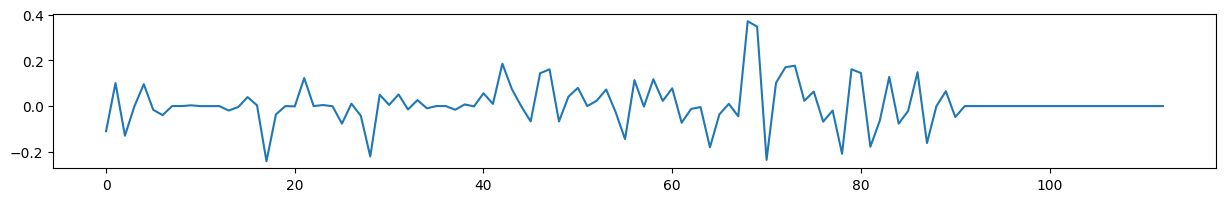

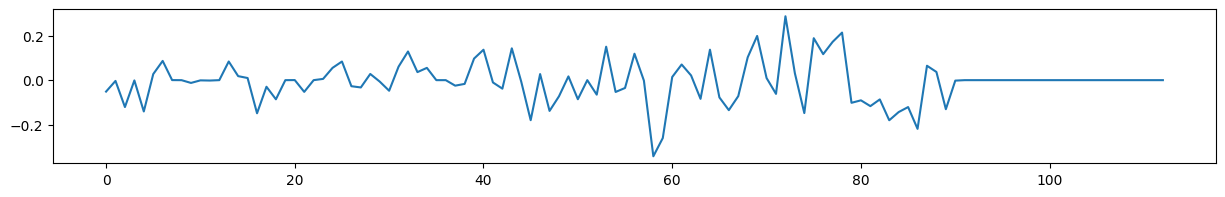

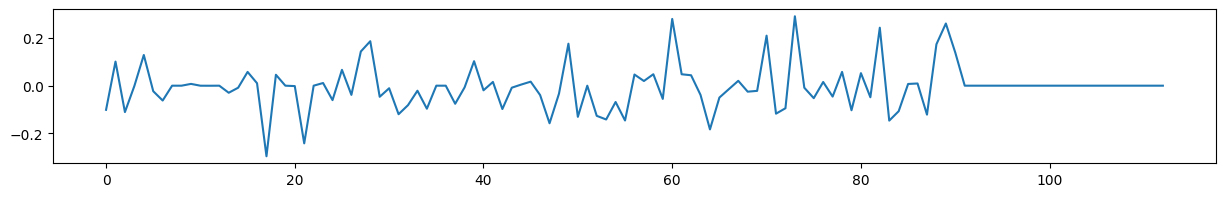

In [12]:
K_eps = 21
H_eps = SpectralClustering.smallest_eigenvecs(
    n, K_eps, eigvals_eps_norm, eigvecs_eps_norm, True
)

Two different eigenvectors give no information, so we can reduce the number of clusters to 19:

Silhouette Score: -0.5868175938362465
Cluster #0 size: 3
Cluster #0 members: FRA, IRQ, PRY
Cluster #1 size: 4
Cluster #1 members: AUT, CHE, ISR, LAO
Cluster #2 size: 4
Cluster #2 members: ARG, AUS, BOL, BRA
Cluster #3 size: 66
Cluster #3 members: BDI, BEL, BEN, BGD, CAF, CAN, CHL, CHN, CIV, CMR, COG, COL, CRI, DNK, DOM, DZA, ECU, ESP, ETH, FIN, GBR, GHA, GRC, GTM, HKG, HND, HRV, HTI, HUN, IDN, KEN, LBN, LBR, LKA, MAR, MEX, MLI, MMR, MNG, MRT, NIC, NLD, NOR, NPL, OMN, POL, PRT, PSE, ROU, SDN, SWE, SYR, TCD, TGO, THA, TUN, TUR, TWN, TZA, UGA, URY, USA, VEN, VNM, YEM, ZAF
Cluster #4 size: 6
Cluster #4 members: KHM, MYS, NER, PER, PHL, RWA
Cluster #5 size: 2
Cluster #5 members: BFA, BIH
Cluster #6 size: 1
Cluster #6 members: BGR
Cluster #7 size: 1
Cluster #7 members: ZMB
Cluster #8 size: 1
Cluster #8 members: ZWE
Cluster #9 size: 1
Cluster #9 members: SLE
Cluster #10 size: 1
Cluster #10 members: SGP
Cluster #11 size: 4
Cluster #11 members: COD, GIN, SLV, SRB
Cluster #12 size: 5
Cluster #12

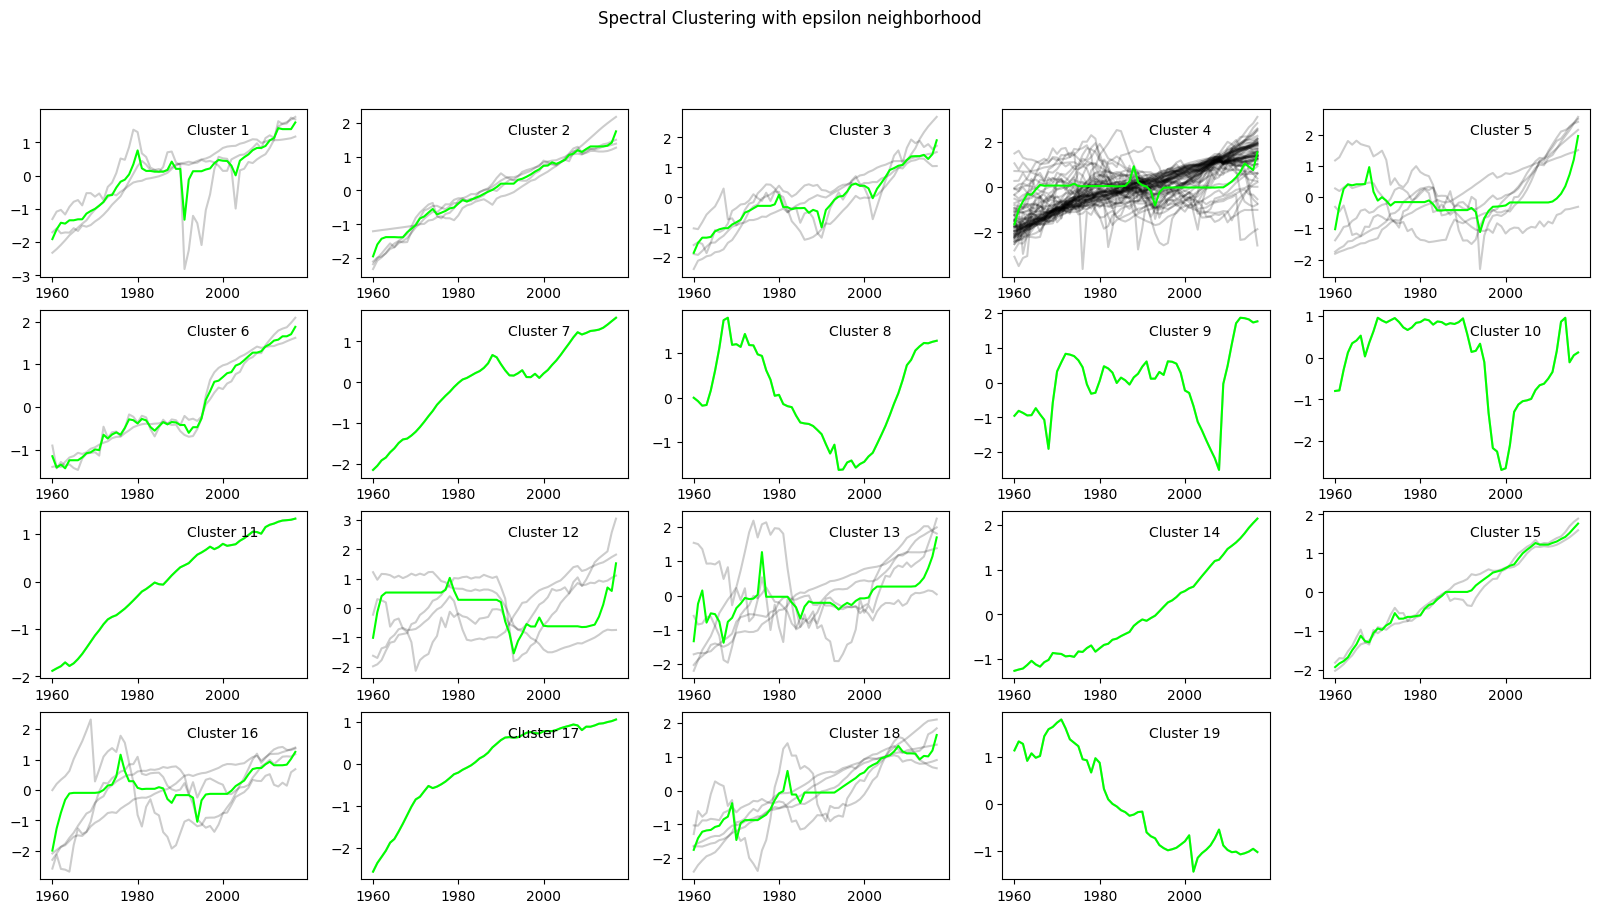

In [13]:
labels_eps = SpectralClustering.kmeans(
    H_eps, K_eps-2
)
score_eps = silhouette_score(scaled_data_gdp, labels_eps)
cluster_centers_eps = TimeSeriesUtils.cluster_centroids(scaled_data_gdp, K_eps-2, labels_eps, T_currency)
clusters = VisualUtils.show_clustering(
    names, 
    K_eps-2, 
    scaled_data_gdp, 
    cluster_centers_eps, 
    labels_eps, 
    score_eps, 
    4, 
    5, 
    start_year, 
    T_currency, 
    "Spectral Clustering with epsilon neighborhood"
)

### Dynamic Time Warping

Here, we construct a $k$-neighbors graph similar to the one before, but with a different distance measure. Instead of Euclidean Distance, Dynamic Time Warpint (DTW) is used to better capture the similaritites and differences of time series. Instead of the concatenated dataset, this section only considers the GDP time series, as it is the one of the highest significance and variance.

In [14]:
W_dtw = SpectralClustering.dtw_knn_graph(n, scaled_df_gdp)

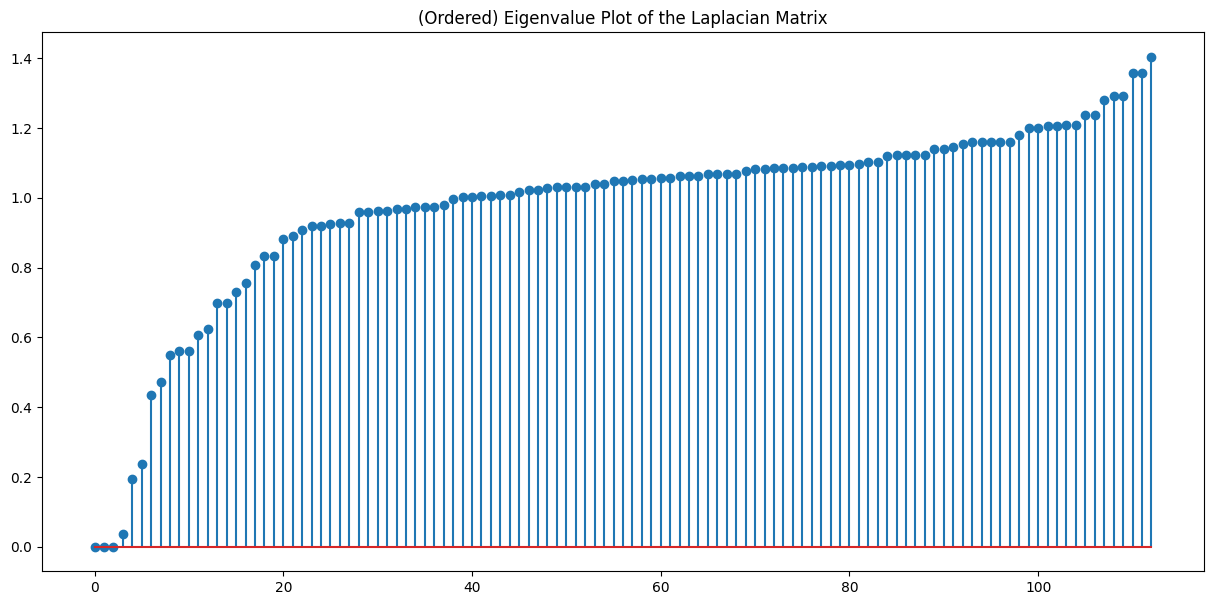

In [15]:
eigvals_dtw_norm, eigvecs_dtw_norm = SpectralClustering.laplacian_eigen(
    n, W_dtw, True, True
)

We conclude 4 clusters are sufficient. We create the H matrix:

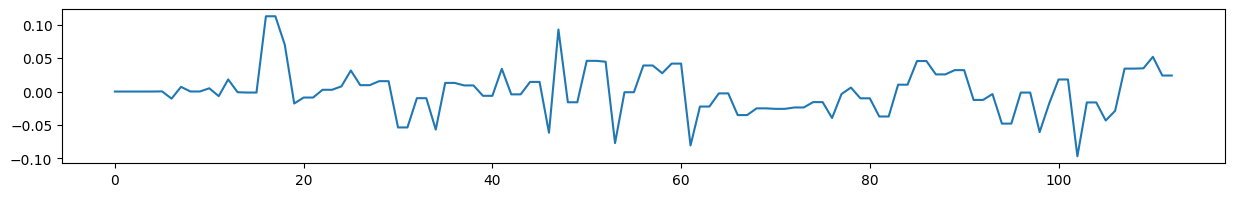

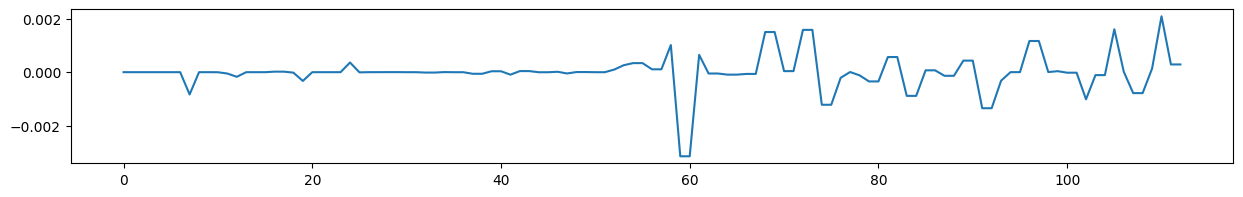

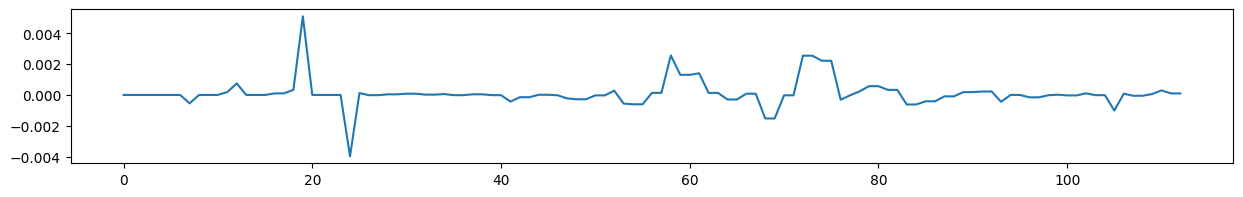

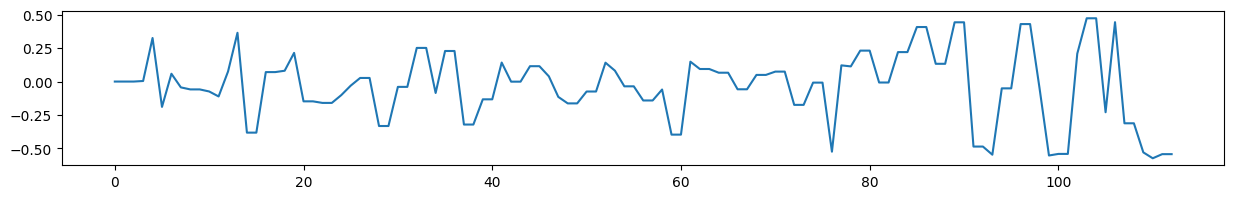

In [16]:
K_dtw = 4
H_dtw = SpectralClustering.smallest_eigenvecs(
    n, K_dtw, eigvals_dtw_norm, eigvecs_dtw_norm, True
)

All of the eigenvectors are relevant, so now we can perform the clustering with 4 clusters

Silhouette Score: -0.07754713619874457
Cluster #0 size: 36
Cluster #0 members: BFA, CAF, CHN, CIV, CMR, COD, DZA, ECU, FRA, GBR, GIN, GRC, HTI, IND, IRL, IRN, KEN, KHM, MEX, MLI, MMR, MNG, MOZ, MYS, NER, NGA, NIC, PAK, PAN, PER, PHL, PRY, PSE, RWA, SAU, TWN
Cluster #1 size: 21
Cluster #1 members: CHE, CHL, EGY, ESP, GTM, HKG, MAR, MDG, OMN, SGP, SLE, SLV, THA, TUN, TUR, VEN, VNM, YEM, ZAF, ZMB, ZWE
Cluster #2 size: 11
Cluster #2 members: BEL, CAN, ROU, RUS, SDN, SEN, SYR, TCD, TZA, UGA, USA
Cluster #3 size: 45
Cluster #3 members: ARG, AUS, AUT, BDI, BEN, BGD, BGR, BIH, BOL, BRA, COG, COL, CRI, DEU, DNK, DOM, ETH, FIN, GHA, HND, HRV, HUN, IDN, IRQ, ISR, ITA, JOR, JPN, KOR, LAO, LBN, LBR, LKA, MRT, MWI, NLD, NOR, NPL, NZL, POL, PRT, SRB, SWE, TGO, URY


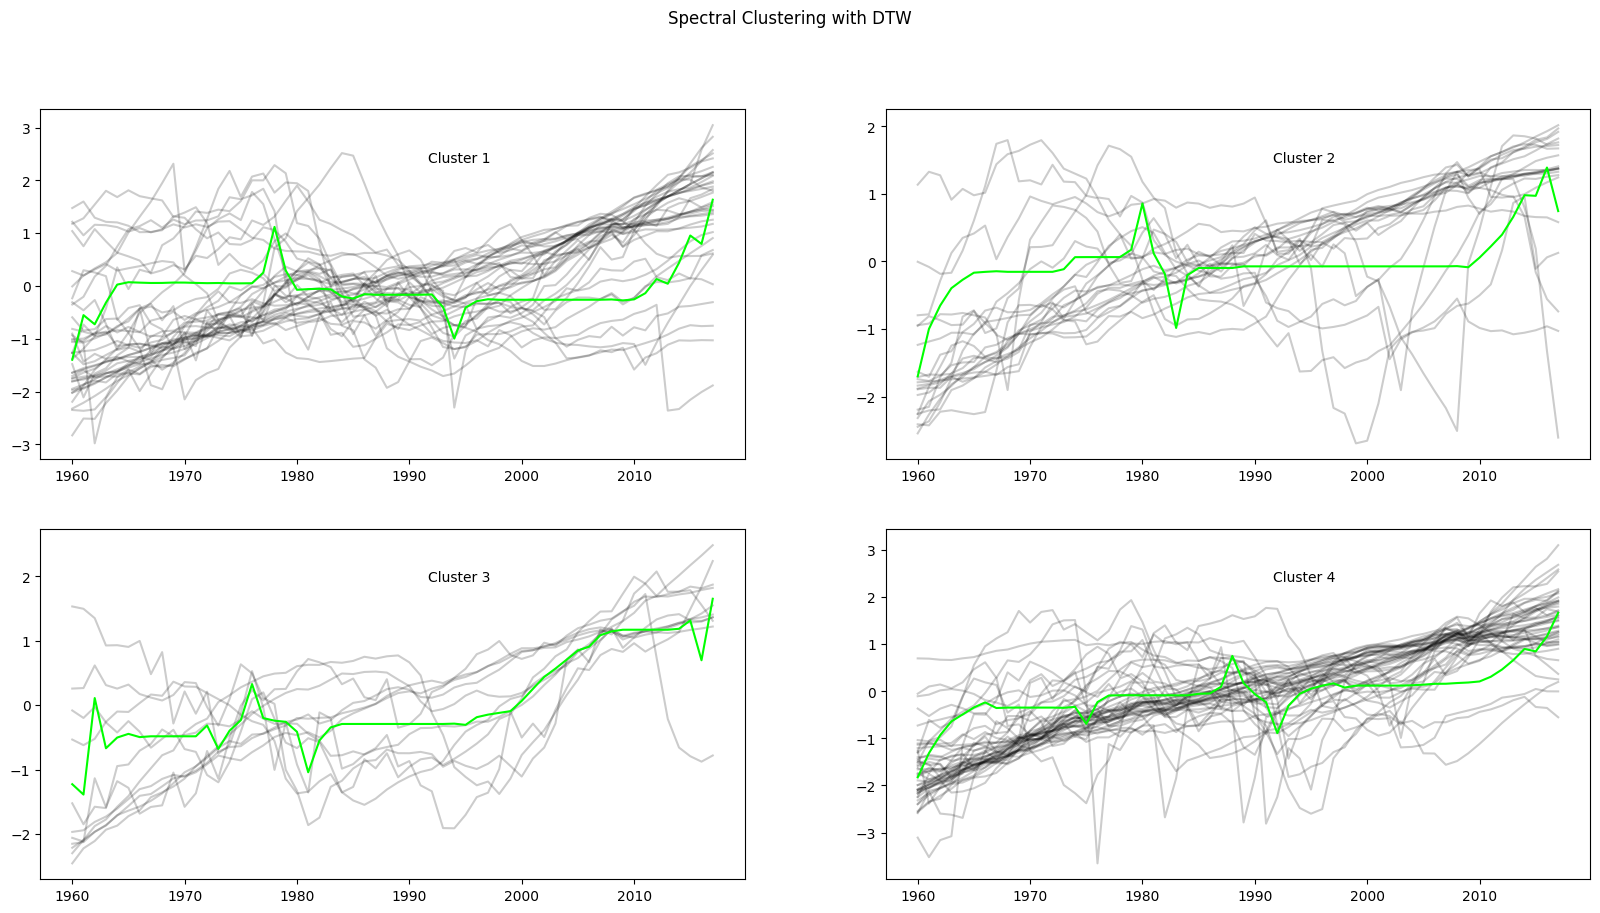

In [17]:
labels_dtw = SpectralClustering.kmeans(
    H_dtw, K_dtw
)

score_dtw = silhouette_score(scaled_data_gdp, labels_dtw)
cluster_centers_dtw = TimeSeriesUtils.cluster_centroids(scaled_data_gdp, K_dtw, labels_dtw, T_currency)
clusters = VisualUtils.show_clustering(
    names, 
    K_dtw, 
    scaled_data_gdp, 
    cluster_centers_dtw, 
    labels_dtw, 
    score_dtw, 
    2, 
    2, 
    start_year, 
    T_currency, 
    "Spectral Clustering with DTW"
)

## Conclusion
In general, spectral clustering fails to identify meaniningful clusters. Apart from achieving significantly lower scores than other algorithms, the clusters are not well balanced and the plots of the clusters indicate countries included in the same cluster do not really present similarities in the evolution of their gdp per capita.